# 6章 学習に関するテクニック

## 6.1 パラメータの更新
ニューラルネットワークの学習の目的は損失関数の値をできるだけ小さくするパラメータを見つけることである。このような問題を解くことを「最適化(optimization)」という。
これまで確率的勾配降下法(SGD)で解いてきたが、問題によってはSGDより優れる最適化手法が存在する。

### 6.1.1 冒険家の話
割愛

### 6.1.2 SGD
SGDの復習。SGDは以下式で表せる。
$W ← W-\eta\frac{\partial L}{\partial W}$


In [2]:
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

### 6.1.3 SGDの欠点

SGDは問題によっては非効率な場合がある。以下関数の最小値を求める問題を考える。

$$f(x,y) = \frac{1}{20}x^{2} + y^{2}$$

上記式の場合y軸方向は勾配が大きいが、x軸方向は小さい。本来最小値は(0,0)の点であるが、勾配の矢印はそちらを向いていない。そのためSGDで最適化を行った場合y軸方向のジグザグばかりでなかなかx軸方向の探索が進まない欠点がある。


/Users/smap3/PycharmProjects/exercise_of_deep_larning_from_scratch/env/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
/Users/smap3/PycharmProjects/exercise_of_deep_larning_from_scratch/env/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


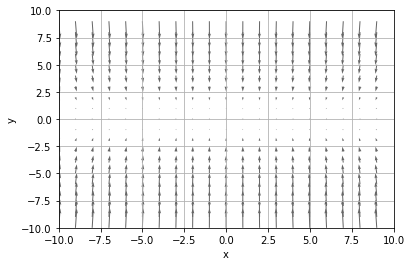

In [14]:
# cf.http://d.hatena.ne.jp/white_wheels/20100327/p3
import numpy as np
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D


def _numerical_gradient_no_batch(f, x, axis='x'):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)
    
    for idx in range(x.size):
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x, axis) # f(x+h)

        x[idx] = tmp_val - h 
        fxh2 = f(x, axis) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val # 値を元に戻す
        
    return grad


def numerical_gradient(f, X):
    if X.ndim == 1:
        return _numerical_gradient_no_batch(f, X)
    else:
        grad = np.zeros_like(X)
        
        for idx, x in enumerate(X):
            if(idx == 0):
                grad[idx] = _numerical_gradient_no_batch(f, x, axis='x')               
            elif(idx == 1):
                grad[idx] = _numerical_gradient_no_batch(f, x, axis='y')
        
        return grad


def function_2(x, axis='x'):
    if(axis == 'x'):
        return np.sum(x**2 / 20)
    elif(axis == 'y'):
        return np.sum(x**2)
  
     
if __name__ == '__main__':
    x = np.arange(-10, 10, 1)
    y = np.arange(-10, 10, 1)
    X, Y = np.meshgrid(x, y)
    
    X = X.flatten()
    Y = Y.flatten()
    
    grad = numerical_gradient(function_2, np.array([X, Y]) )
    
    plt.figure()
    plt.quiver(X, Y, -grad[0], -grad[1],  angles="xy",color="#666666")#,headwidth=10,scale=40,color="#444444")
    plt.xlim([-10, 10])
    plt.ylim([-10, 10])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid()
    plt.legend()
    plt.draw()
    plt.show()

### 6.1.4 Momentum

モーメンタム(Momentum)という手法は以下式で表される。

$$
v ← \alpha v -\eta \frac{\partial L}{\partial W} \\
W ← W + v
$$

$W$:更新する重みパラメータ、$\frac{\partial L}{\partial W}$:Wに関する損失関数の勾配、$\eta$:学習係数、$v$:物理で言う速度である。
$\alpha v$では何も力を受けないときに徐々に減速するための役割を担う($\alpha$は0.9などを設定する)

お椀を転がるボールのように更新していく。これは同じ方向に力を受け続けたら加速し(x軸)、逆方向の力が加えられると減速する(y軸)イメージと類似している。


In [16]:
class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key]
            params[key] += self.v[key]

### 6.1.5 AdaGrad

ニューラルネットワークの学習では学習係数が重要であり、小さすぎるとなかなか学習が進まず大きすぎると発散して学習ができない。

学習係数に関するテクニックで、「学習係数の減衰(learning rate decay)」という方法がある。学習が進むに連れて学習係数を小さくする手法である。パラメータ全体の学習係数の値を一括して下げる方法もあるが、AdaGradでは「1つ1つ」のパラメータに対して減衰を行なう。AdaGradの更新方法は以下である。

$$
h \gets h + \frac{\partial L}{\partial W} \odot \frac{\partial L}{\partial W}
$$

$$
W \gets W + \eta \frac{1}{\sqrt h} \frac{\partial L}{\partial W}
$$

$W$:更新する重みパラメータ、$\frac{\partial L}{\partial W}$:Wに関する損失関数の勾配、$\eta$:学習係数、$h$:これまでの勾配の2乗和($\odot$は行列の要素ごとの掛け算)。パラメータ更新の際に$\frac{1}{\sqrt h}$を乗算し学習のスケールを調整する。大きく更新された要素は学習係数が小さくなる。

AdaGradは過去の勾配を全て二乗和として記録するため進めるほど更新料が小さくなりつつける。そこでRMSPropという手法では過去のすべての勾配を均一に考えるのではなく、過去の勾配の影響は小さくし、直近の勾配情報を大きく影響を与えるようにする。(指数移動平均)

AdaGradの実装は以下となる。


In [ ]:
class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

### 6.1.6 Adam

お椀に転がるボールのような更新を行なうMomentumと、パラメータの要素ごとに更新料の減衰を行なうAdaGradを組み合わせた手法がAdamである。効率的にパラメータ空間を探索でき、ハイパーパラメータの「バイアス補正(偏りの補正)」が行われる。

Adamの実装は以下。
Adamは3つのハイパーパラメータを設定する。学習係数$\alpha$、一次モーメント用の係数$\beta_{1}$、二次モーメント用係数$\beta_{2}$。論文では$\beta_{1}$=0.9、$\beta_{2}$=0.999で多くの場合で上手くいくと述べられている。


In [ ]:
class Adam:

    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in params.keys():
            #self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
            #self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)
            
            #unbias_m += (1 - self.beta1) * (grads[key] - self.m[key]) # correct bias
            #unbisa_b += (1 - self.beta2) * (grads[key]*grads[key] - self.v[key]) # correct bias
            #params[key] += self.lr * unbias_m / (np.sqrt(unbisa_b) + 1e-7)

### 6.1.7 どの更新手法を用いるか？



/Users/smap3/PycharmProjects/exercise_of_deep_larning_from_scratch/env/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


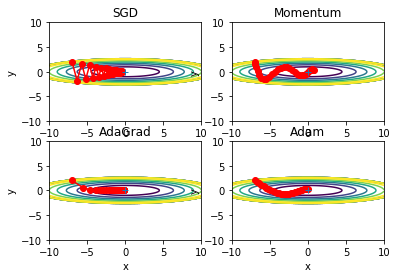

In [17]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from src.optimizer import *


def f(x, y):
    return x**2 / 20.0 + y**2


def df(x, y):
    return x / 10.0, 2.0*y

init_pos = (-7.0, 2.0)
params = {}
params['x'], params['y'] = init_pos[0], init_pos[1]
grads = {}
grads['x'], grads['y'] = 0, 0


optimizers = OrderedDict()
optimizers["SGD"] = SGD(lr=0.95)
optimizers["Momentum"] = Momentum(lr=0.1)
optimizers["AdaGrad"] = AdaGrad(lr=1.5)
optimizers["Adam"] = Adam(lr=0.3)

idx = 1

for key in optimizers:
    optimizer = optimizers[key]
    x_history = []
    y_history = []
    params['x'], params['y'] = init_pos[0], init_pos[1]
    
    for i in range(30):
        x_history.append(params['x'])
        y_history.append(params['y'])
        
        grads['x'], grads['y'] = df(params['x'], params['y'])
        optimizer.update(params, grads)
    

    x = np.arange(-10, 10, 0.01)
    y = np.arange(-5, 5, 0.01)
    
    X, Y = np.meshgrid(x, y) 
    Z = f(X, Y)
    
    # for simple contour line  
    mask = Z > 7
    Z[mask] = 0
    
    # plot 
    plt.subplot(2, 2, idx)
    idx += 1
    plt.plot(x_history, y_history, 'o-', color="red")
    plt.contour(X, Y, Z)
    plt.ylim(-10, 10)
    plt.xlim(-10, 10)
    plt.plot(0, 0, '+')
    #colorbar()
    #spring()
    plt.title(key)
    plt.xlabel("x")
    plt.ylabel("y")
    
plt.show()

上記ではAdaGradが一番良く見えるが、扱う問題やハイパーパラメータ(学習係数など)の設定値によって結果が変わる。


### 6.1.8 MNISTデータセットによる更新手法の比較

MNISTを対象に4つの更新手法の比較を行なう。


===========iteration:0===========
SGD:2.36521284066
Momentum:2.34537275011
AdaGrad:2.22104501819
Adam:2.1870800864


===========iteration:100===========
SGD:1.48456273248
Momentum:0.325060598643
AdaGrad:0.153036624764
Adam:0.230585299337


===========iteration:200===========
SGD:0.727890606891
Momentum:0.235794270445
AdaGrad:0.11509169707
Adam:0.133266722382


===========iteration:300===========
SGD:0.615651583762
Momentum:0.187522430865
AdaGrad:0.0799886188244
Adam:0.145038274825


===========iteration:400===========
SGD:0.540487484719
Momentum:0.180059194963
AdaGrad:0.0675677976226
Adam:0.112541213809


===========iteration:500===========
SGD:0.469815795511
Momentum:0.205706184277
AdaGrad:0.0600932342145
Adam:0.123140541932


===========iteration:600===========
SGD:0.384826232556
Momentum:0.179244024102
AdaGrad:0.0490103374775
Adam:0.0866054169778


===========iteration:700===========
SGD:0.284851076143
Momentum:0.0581067070481
AdaGrad:0.0332084196503
Adam:0.0608779112661


===========iteration:800===========
SGD:0.335301673071
Momentum:0.113315597088
AdaGrad:0.0562280389978
Adam:0.0781103462844


===========iteration:900===========
SGD:0.35814911006
Momentum:0.108310176042
AdaGrad:0.08824054641
Adam:0.103355176959


===========iteration:1000===========
SGD:0.234264295064
Momentum:0.0986747502045
AdaGrad:0.0506454540046
Adam:0.0894517341021


===========iteration:1100===========
SGD:0.264615815257
Momentum:0.0691690508017
AdaGrad:0.0429805078074
Adam:0.0537260606211


===========iteration:1200===========
SGD:0.206429122532
Momentum:0.0433315275413
AdaGrad:0.0246323026696
Adam:0.0234086119077


===========iteration:1300===========
SGD:0.286266254622
Momentum:0.119290090896
AdaGrad:0.0424446099291
Adam:0.0574741716302


===========iteration:1400===========
SGD:0.173681762073
Momentum:0.0572317935526
AdaGrad:0.0256051356087
Adam:0.0480660235138


===========iteration:1500===========
SGD:0.267637289665
Momentum:0.106020602567
AdaGrad:0.0372252004695
Adam:0.0676614907455


===========iteration:1600===========
SGD:0.221664804705
Momentum:0.199423462474
AdaGrad:0.104168998471
Adam:0.134287257037


===========iteration:1700===========
SGD:0.167431437261
Momentum:0.059685292398
AdaGrad:0.0259113005557
Adam:0.0267586883567


===========iteration:1800===========
SGD:0.0970496993112
Momentum:0.0193055767589
AdaGrad:0.0224675793566
Adam:0.0155859956683


===========iteration:1900===========
SGD:0.168337577376
Momentum:0.0307487485122
AdaGrad:0.0207297490481
Adam:0.024736231273


/Users/smap3/PycharmProjects/exercise_of_deep_larning_from_scratch/env/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


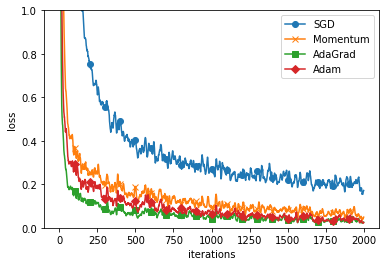

In [22]:
import os
import sys
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import matplotlib.pyplot as plt
from src.mnist import load_mnist
from src.util import smooth_curve
from src.multi_layer_net import MultiLayerNet
from src.optimizer import *


# 0:MNISTデータの読み込み==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1:実験の設定==========
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()
#optimizers['RMSprop'] = RMSprop()

networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(
        input_size=784, hidden_size_list=[100, 100, 100, 100],
        output_size=10)
    train_loss[key] = []    


# 2:訓練の開始==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print( "===========" + "iteration:" + str(i) + "===========")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3.グラフの描画==========
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()

SGD以外の手法が早く学習できている。AdaGradが最も早く学習出来ているように見える。一般にSGDよりほかの3つの手法のほうが早く学習でき、時には最終的な認識性能も高くなる。



## 6.2 重みの初期値

ニューラルネットワークでは重みの初期値も重要である。


### 6.2.1 重みの初期値を0にする？

科学集を抑えて汎化性能を高める手法として「Weight decay(荷重減衰)」がある。この手法は重みパラメータの値が小さくなるように学習を行なうことを目的としている。(過学習を起きにくくする)

初期値を小さい状態からスタートするのが正攻法である(これまでもガウス分布から生成される値を0.01倍した値などを利用してきた)が、全て0に設定するのは不適当である。

全てを0(正確には重みを均一な値に設定)にすると、誤差逆伝播法において全ての重みの値が均一に更新されてしまうため。1層目も2層目も同じように重みは対象的な値を持つようになってしまい、上手く学習できない。

重みが均一になる(対象的な構造になる)ことを防ぐには、ランダムな初期値が必要。



### 6.2.2 隠れ層のアクティベーション分布

隠れ層のアクティベーション(活性化関数の後の出力データ)の分布を観察することから多くの知見が得られる。重みの初期値によって隠れ層のアクティベーションがどのように変化するか確認する。

5層のニューラルネットワークで活性化関数にシグモイド関数を使用する。ランダムに生成した入力データから角層のアクティベーションのデータ分布をヒストグラムで描画する。


/Users/smap3/PycharmProjects/exercise_of_deep_larning_from_scratch/env/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


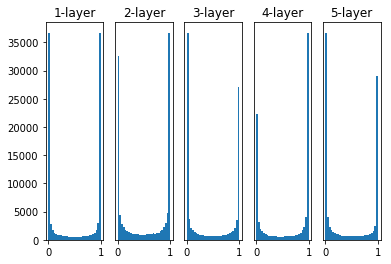

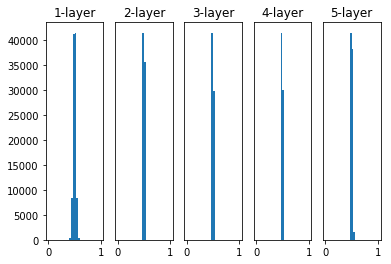

In [30]:
import numpy as np
import matplotlib.pyplot as plt


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def ReLU(x):
    return np.maximum(0, x)


def tanh(x):
    return np.tanh(x)
    
input_data = np.random.randn(1000, 100)  # 1000個のデータ
node_num = 100  # 各隠れ層のノード（ニューロン）の数
hidden_layer_size = 5  # 隠れ層が5層
activations = {}  # ここにアクティベーションの結果を格納する
activations01 = {}  # ここにアクティベーションの結果を格納する
activationsxa = {}  # ここにアクティベーションの結果を格納する

x = input_data
x01 = input_data
xxa = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
        x01 = activations01[i-1]
        xxa = activationsxa[i-1]

    # 初期値の値をいろいろ変えて実験しよう！
    w = np.random.randn(node_num, node_num) * 1
    w01 = np.random.randn(node_num, node_num) * 0.01
    wxa = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    # w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)


    a = np.dot(x, w)
    a01 = np.dot(x01, w01)
    axa = np.dot(xxa, wxa)


    # 活性化関数の種類も変えて実験しよう！
    z = sigmoid(a)
    z01 = sigmoid(a01)
    zxa = sigmoid(axa)

    # z = ReLU(a)
    # z = tanh(a)

    activations[i] = z
    activations01[i] = z01
    activationsxa[i] = zxa

# ヒストグラムを描画(標準偏差1)
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()


# ヒストグラムを描画(標準偏差0.1)
for i, a in activations01.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

上記の上表を見ると、標準偏差1のガウス分布で与えられた重みの初期値において各層のアクティベーションは0や1に偏っている。
活性化関数であるシグモイド関数は出力が0や1に近づくほど微分は0に近づくため、逆伝播の際には勾配の値がどんどん小さくなって消えてしまう。これを「勾配消失問題(gradient vanishing)」と呼び、層が深くなるほど深刻になってくる。

上記の下表である標準偏差0.1のガウス分布で与えられた重みの初期値では0.5付近に集中している。この場合、勾配消失の問題は発生しないが表現力に大きな問題がある。複数のニューロンが同じ値を出力すれば、いわば1個のニューロンでも同じ結果であるため表現力が乏しいと言える。

これらのことから各層のアクティベーションの分布は適度な広がりを持つことが求められることが分かる。

次にディープラーニングのフレームワークで標準的に利用されている「Xavierの初期値」(Xavier Glorotの論文で推奨される重みの初期値)で確認してみる。

この論文では角層のアクティベーションを同じ広がりのある分布にすることを目的として、適切な重みのスケールを導いた。前層のノードの個数を$n$とした場合、$\frac{1}{\sqrt n}$の標準偏差を持つガウス分布を使うと良い。これは前層のノードの数が多ければ多いほど初期値として設定する重みは小さくなることとなる。

確認結果は以下となる。上位層につれていびつになるが、広がりを持った分布となっている。これによりシグモイド関数でも表現力を損なわずに効率的に学習が出来る。

いびつである点については活性化関数に$tanh$(双曲線関数)を用いれば改善される。tanhが原点で対象なカーブであるためである。一般的に活性化関数は減点対象であることが望ましい性質として知られる。



/Users/smap3/PycharmProjects/exercise_of_deep_larning_from_scratch/env/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


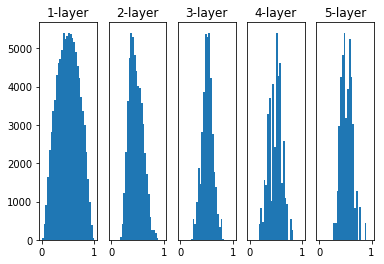

In [31]:
# ヒストグラムを描画(標準偏差 Xavier)
for i, a in activationsxa.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()